## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Урок 4. Image Segmentation

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [42]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### 1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# dst_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/archive.zip"

In [6]:
# from zipfile import ZipFile
# zipfile = ZipFile(dst_path)
# zipfile.extractall()

### Step 1
### Starter: Makeup. Lips Segmentation.

In [7]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [8]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [57]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# list.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('C:/Users/Admin/Desktop/set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
# df1 = pd.read_csv('/content/set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 9 columns


In [58]:
df1.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [59]:
df1.tail(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
995,image00000996.jpg,1280,720,Lips,692,343,780,412,mask00000996.png
996,image00000997.jpg,1280,720,Lips,620,348,712,402,mask00000997.png
997,image00000998.jpg,1280,720,Lips,700,337,788,405,mask00000998.png
998,image00000999.jpg,1280,720,Lips,679,337,762,389,mask00000999.png
999,image00001000.jpg,1280,720,Lips,667,359,749,412,mask00001000.png


In [60]:
plotPerColumnDistribution(df1, 10, 5)

<Figure size 2400x512 with 0 Axes>

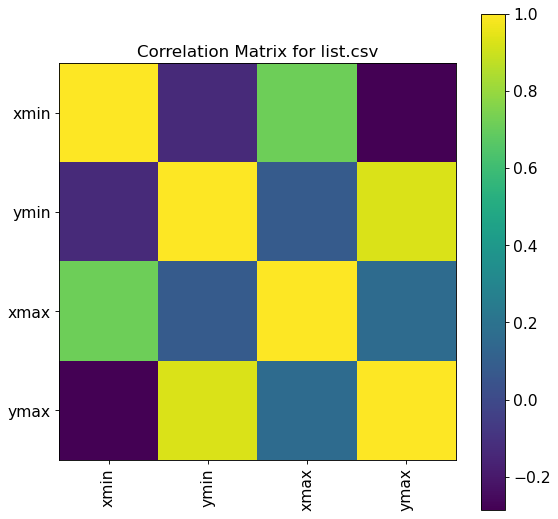

In [14]:
plotCorrelationMatrix(df1, 8)

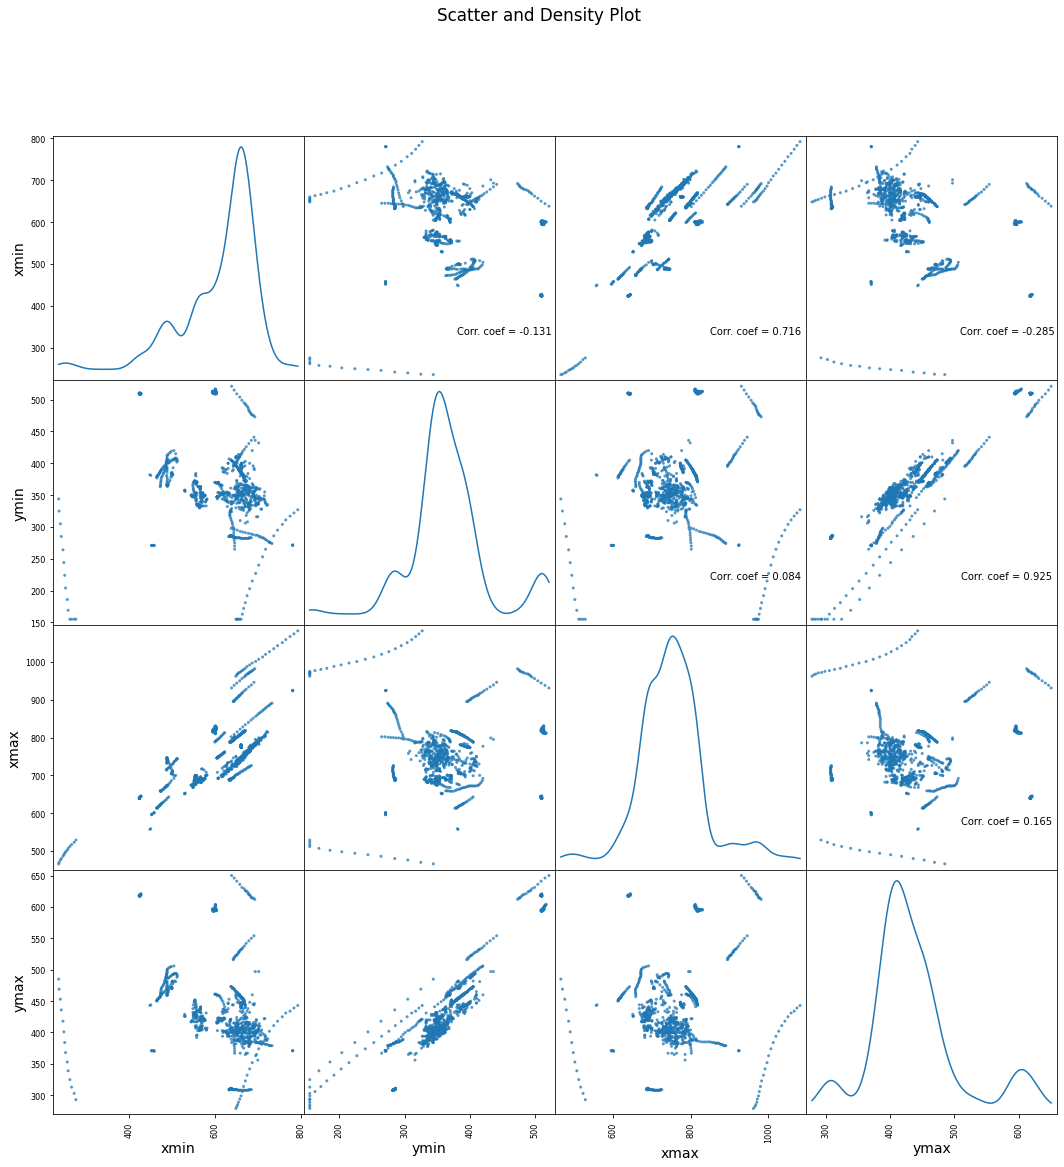

In [15]:
plotScatterMatrix(df1, 18, 10)

### Step 2

In [16]:
# path_image = "/content/set-lipstick-original/720p"
# path_mask = "/content/set-lipstick-original/mask"
path_image = "C:/Users/Admin/Desktop/set-lipstick-original/720p/"
path_mask = "C:/Users/Admin/Desktop/set-lipstick-original/mask/"

In [17]:
labels = ['NoLips','Lips']

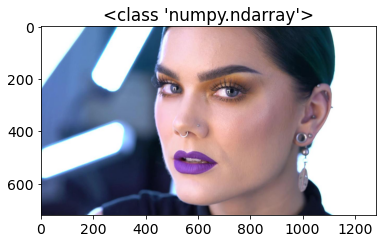

In [18]:
image12069 = plt.imread(path_image+'/image00012069.jpg')

fig, ax = plt.subplots()

ax.imshow(image12069)
ax.set_title(type(image12069))

# fig.set_figwidth(7)    #  ширина и
# fig.set_figheight(7)    #  высота "Figure"

plt.show()

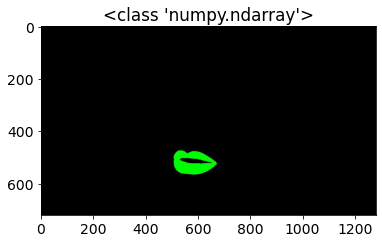

In [19]:
image12069 = plt.imread(path_mask+'/mask00012069.png')

fig, ax = plt.subplots()

ax.imshow(image12069)
ax.set_title(type(image12069))

# fig.set_figwidth(7)    #  ширина и
# fig.set_figheight(7)    #  высота "Figure"

plt.show()

In [20]:
images = []

for root, dirs, files in os.walk(path_image):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            images.append(f)
        else:
            break

In [21]:
masks = []

for root, dirs, files in os.walk(path_mask):
    for name in files:
        f = os.path.join(root, name)
        if 'mask' in f:
            masks.append(f)
        else:
            break

In [22]:
len(images), len(masks), images[-1], masks[-1]

(28594,
 28540,
 'C:/Users/Admin/Desktop/set-lipstick-original/720p/image00028594.jpg',
 'C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00028594.png')

In [32]:
images[0], masks[0]

('C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000001.jpg',
 'C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000001.png')

In [33]:
images[0][-12:-4], masks[0][-12:-4]

('00000001', '00000001')

In [34]:
images_w_mask = []

for img in images:
    for mask in masks:
        if img[-12:-4] == mask[-12:-4]:
            images_w_mask.append(img)
            break

In [35]:
masks_adapt = []

for img in images_w_mask:
    masks_adapt.append(f"C:/Users/Admin/Desktop/set-lipstick-original/mask/mask{img[-12:-4]}.png")

In [36]:
len(images_w_mask), len(masks_adapt), images_w_mask[-1], masks_adapt[-1]

(28540,
 28540,
 'C:/Users/Admin/Desktop/set-lipstick-original/720p/image00028594.jpg',
 'C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00028594.png')

In [37]:
images_w_mask[7777], masks_adapt[7777]

('C:/Users/Admin/Desktop/set-lipstick-original/720p/image00007778.jpg',
 'C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00007778.png')

In [38]:
df = pd.DataFrame({'images': images_w_mask, 'masks': masks_adapt})
# df = pd.DataFrame({'images': images, 'masks': masks}) - ValueError: arrays must all be same length
# Отсортируем  датафрейм по значениям
df.sort_values(by='images', inplace=True)
# Используем функцию, благодаря которой индексация значений будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые 5 значений нашего датафрейма
print(df.head(5))

                                                                images  \
0  C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000001.jpg   
1  C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000002.jpg   
2  C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000003.jpg   
3  C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000004.jpg   
4  C:/Users/Admin/Desktop/set-lipstick-original/720p/image00000005.jpg   

                                                                masks  
0  C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000001.png  
1  C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000002.png  
2  C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000003.png  
3  C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000004.png  
4  C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00000005.png  


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  28540 non-null  object
 1   masks   28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


### Step 3

In [40]:
img = np.asarray(Image.open(images_w_mask[0])).astype('float')
img.shape

(720, 1280, 3)

In [44]:
img = torch.as_tensor(img)/255
img = img.unsqueeze(0)
print(img.shape)
img = img.permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)

torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


In [45]:
mask_it = np.asarray(Image.open(masks_adapt[-1])).astype('int')
mask_it.shape

(720, 1280, 3)

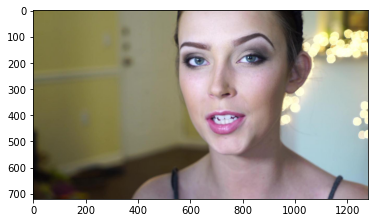

In [46]:
plt.imshow(Image.open(images_w_mask[-1]))

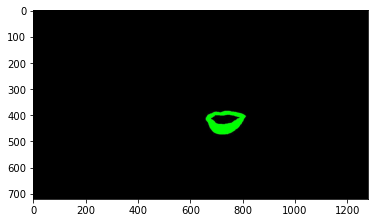

In [47]:
plt.imshow(mask_it)

In [51]:
masks_adapt[-1]

'C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00028594.png'

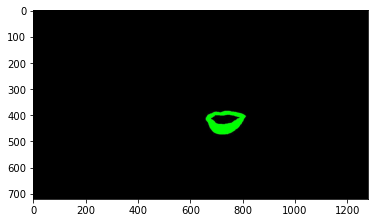

In [52]:
plt.imshow(Image.open('C:/Users/Admin/Desktop/set-lipstick-original/mask/mask00028594.png'))

In [61]:
df1 = pd.read_csv('C:/Users/Admin/Desktop/set-lipstick-original/list.csv', delimiter=',')
# df1 = pd.read_csv('/content/set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 28594 rows and 9 columns


In [62]:
df1.tail(1)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [64]:
mask_it[381, 657:817, :]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

In [35]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index]).convert('RGB')
        img = img.resize((256,256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        img = img.permute(2,0,1)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        #img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        
        
        # делаем ресайз картинки на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        lab=lab.squeeze(0).squeeze(0)
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [36]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [37]:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#### 2.	И затем обучить Модель на выбор из segmentation_models_pytorch

![image](segmentation_models_pytorch.png)  
https://pypi.org/project/segmentation-models-pytorch/

In [38]:
# pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [39]:
learning_rate = 0.001
epochs = 5

In [40]:
segmodel = smp.Unet('resnet101', classes=2, activation='softmax').to(device)

In [41]:
optimizer = torch.optim.Adam(segmodel.parameters())

#### 3.	*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.